# Обучение CNN модели

In [2]:
import numpy as np
import pandas as pd
import os
from ultralytics import YOLO
from PIL import Image
import cv2
import matplotlib.pyplot as plt

## Загрузка данных

In [3]:
train_data_path = "images/train"
test_data_path = "images/test"

train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")

Загрузка сегментатора, который мы обучили в ```finetune_seg.ipynb```

In [4]:
seg_model = YOLO("runs/segment/train/weights/best.pt")

Посмотрим на пример работы модели

In [5]:
example = "images/train/A2miww5mfx/A2miww5mfx_R_028.png"
results = seg_model(example)


image 1/1 d:\python\manioka\images\train\A2miww5mfx\A2miww5mfx_R_028.png: 32x640 6 roots, 183.0ms
Speed: 3.1ms preprocess, 183.0ms inference, 197.0ms postprocess per image at shape (1, 3, 32, 640)


In [6]:
example_image = Image.open(example)
display(example_image)

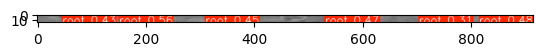

In [7]:
img = results[0].plot()
plt.imshow(img)

Что-то да нашлось :)

### Извлечение сегментов

Теперь нужно подготовить датасет для обучения модели-регрессора. Сперва извлечём сегменты

In [8]:
models = {"early" : YOLO("seg_models/best_early.pt"),
          "late" : YOLO("seg_models/best_late.pt"),
          "full" : YOLO("seg_models/best_full.pt"),
          "best" : YOLO("seg_models/best.pt")}

def get_segmented_images(models, image_paths, display_image=False):
    """Извлечение детектированных сегментов"""
    best_res = None
    for model in models.keys():
        model = models[model]
        results = model(image_paths, verbose=False)
        if best_res is None or len(results[0].boxes.xyxy) >= len(best_res[0].boxes.xyxy):
            best_res = results
        # if len(results[0].boxes.xyxy) != 0:
        #     break

    results = best_res

    if len(results[0].boxes.xyxy) == 0:
        # в случае отсутствия детекций
        return [Image.open(img) for img in image_paths]
        
    segmented_images = []
    
    for img_path, result in zip(image_paths, results):
        original_image = Image.open(img_path)
        
        # Пропускаем изображения без детекций
        if len(result.boxes.xyxy) == 0:
            continue 
            
        # Оставляем сегменты
        for box in result.boxes.xyxy:
            x1, y1, x2, y2 = map(int, box.tolist())
            segment = original_image.crop((x1, y1, x2, y2))
            segmented_images.append(segment)
            

    # Отрисовка для демонстрации
    if display_image and segmented_images:
        fig, axes = plt.subplots(1, len(segmented_images), figsize=(15, 10))
        if len(segmented_images) == 1:
            axes = [axes]
        for ax, img in zip(axes, segmented_images):
            ax.imshow(img)
            ax.axis("off")
        plt.show()

    return segmented_images

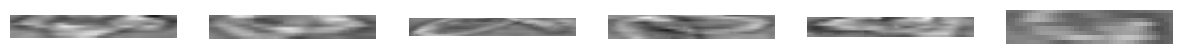

[<PIL.Image.Image image mode=RGBA size=65x9>,
 <PIL.Image.Image image mode=RGBA size=56x8>,
 <PIL.Image.Image image mode=RGBA size=100x11>,
 <PIL.Image.Image image mode=RGBA size=69x10>,
 <PIL.Image.Image image mode=RGBA size=76x9>,
 <PIL.Image.Image image mode=RGBA size=39x8>]

In [9]:
get_segmented_images(models, [example], display_image=True)

### Загрузка серии срезов

In [10]:
def get_images(img_root : str, folder : str, side : str, start : int, end : int) -> list[str]:
    """Получение списка последовательности изображений

    Args:
        img_root (str): корневая папка с изображениями
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        list[str]: список путей до изображений
    """
    images = []
    for i in range(start, end + 1):
        path = os.path.join(
            img_root,
            folder,
            f"{folder}_{side}_{i:03d}.png"
        )
        if os.path.exists(path):
            images.append(path)

    return images

In [11]:
samples = get_images(train_data_path, folder="A2miww5mfx", side="R", start=28, end=35)
print(samples)

['images/train\\A2miww5mfx\\A2miww5mfx_R_028.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_029.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_030.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_031.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_032.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_033.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_034.png', 'images/train\\A2miww5mfx\\A2miww5mfx_R_035.png']


### Компоновка сегментов

In [12]:
def merge_segmented_images(root: str, folder: str, side: str, start: int, end: int) -> Image:
    """Компоновка сегментов по серии срезов

    Args:
        root (str): корневой путь
        folder (str): папка корня
        side (str): (L|R) сторона
        start (int): начальный срез
        end (int): конечный срез

    Returns:
        Image: Итоговое изображение PIL.Image
    """
    images_in_range = get_images(root, folder, side, start, end)
    segmented_images = get_segmented_images(models, images_in_range)

    total_width = sum(img.width for img in segmented_images)
    max_height = max(img.height for img in segmented_images)
    res = Image.new("RGBA", (total_width, max_height * len(segmented_images)), (0, 0, 0, 0))
    sqr_width = int(np.ceil(np.sqrt(total_width * max_height)))
    x_offset = 0
    y_offset = 0
    actual_width = 0
    for segment in segmented_images:
        if x_offset + segment.width > sqr_width:
            actual_width = max(actual_width, x_offset)
            x_offset = 0
            y_offset += max_height
        res.paste(segment, (x_offset, y_offset))
        x_offset += segment.width
    actual_width = max(actual_width, x_offset)
    actual_height = y_offset + max_height
    res = res.crop((0, 0, actual_width, actual_height))

    return res

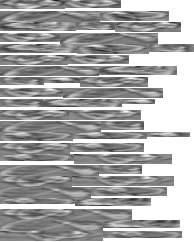

In [13]:
img = merge_segmented_images(train_data_path, folder="A2miww5mfx", side="R", start=28, end=35)
display(img)

Изображения компонуются так, чтобы итоговые пропорции были близки к квадратному изображению

## Датасет для регрессора

Теперь создадим датасет для свёрточного регрессора

In [14]:
output_root = "merged_images"

output_train = os.path.join(output_root, "train")
output_test = os.path.join(output_root, "test")

os.makedirs(output_train, exist_ok=True)
os.makedirs(output_test, exist_ok=True)

In [15]:
from tqdm import tqdm

In [16]:
def generate_regression_dataset(df : pd.DataFrame, output : str, src : str, type : str):
    paths = []
    
    for _, row in tqdm(df.iterrows(), total = len(df), desc="Генерация датасета"):
        img = merge_segmented_images(
            root=src,
            folder=row["FolderName"],
            side=row["Side"],
            start=row["Start"],
            end=row["End"]
        )
        img_path = os.path.join(output, f'{row["ID"]}.png')
        img.save(img_path)
        paths.append(img_path)
        
    df["ImageSegments"] = paths
    df.to_csv(f"{type}CNN.csv")
    return df

In [17]:

if not os.path.exists("trainCNN.csv"):
    new_train_df = generate_regression_dataset(train_df, output_train, train_data_path, type = "train")
else:
    new_train_df = pd.read_csv("trainCNN.csv")

In [18]:
if not os.path.exists("testCNN.csv"):
    new_test_df = generate_regression_dataset(test_df, output_test, test_data_path, type = "test")
else:
    new_test_df = pd.read_csv("testCNN.csv")

## Обучение модели

Предварительно будем трансформировать данные

In [19]:
import lightning as L
from torch.utils.data import DataLoader, Dataset
import torch
from torchvision.transforms import v2
from torch import nn

### Датасет

In [20]:
class RootVolumeDataset(Dataset):
    def __init__(self, df : pd.DataFrame, transform = None, is_train = True):
        super().__init__()
        self.df = df
        self.transform = transform
        self.is_train = is_train

    def __getitem__(self, index):
        image = Image.open(self.df['ImageSegments'].iloc[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.is_train:
            label = self.df['RootVolume'].iloc[index]

            return image, torch.tensor(label, dtype=torch.float32)

        return image

    def __len__(self):
        return len(self.df)

Воспроизводимость результатов

In [21]:
def seed_everything(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False
    L.pytorch.seed_everything(seed, workers=True)
    
seed_everything(0)

Seed set to 0


In [22]:
train_transform = v2.Compose([
    v2.Resize(size=(128, 128), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

test_transform = v2.Compose([
    v2.Resize(size=(128, 128), antialias=True),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),  
    v2.Normalize(mean=[0.5], std=[0.5])
])

In [23]:
train_dataset = RootVolumeDataset(new_train_df, train_transform)
test_dataset = RootVolumeDataset(new_test_df, test_transform, is_train = False)

In [24]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

### Регрессор

In [25]:
class RootVolumeRegressor(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.lr = lr

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # Fully Connected Regression Head
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Regression output
        )

        self.criterion = nn.MSELoss()

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images).squeeze()
        loss = self.criterion(preds, targets)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [26]:
model = RootVolumeRegressor()

In [27]:
if os.path.exists("cnn_models/model.ckpt"):
    state_dict = torch.load("cnn_models/model.ckpt")['state_dict']
    model.load_state_dict(state_dict)
else:
    trainer = L.Trainer(max_epochs = 20)
    trainer.fit(model, train_dataloader)
    os.makedirs("cnn_models", exist_ok=True)
    trainer.save_checkpoint("cnn_models/model.ckpt")

### Тест

In [28]:
def get_model_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds, targets = [], []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Predict
            preds.extend(outputs.cpu().numpy().flatten())
            targets.extend(labels.cpu().numpy().flatten())

    return np.array(preds), np.array(targets)

train_preds, target = get_model_preds(model, train_dataloader)

In [29]:
def calculate_rmse(preds, targets):
    """
    Compute Root Mean Squared Error (RMSE) between predictions and ground truth targets.
    """
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    
    return np.sqrt(np.mean((preds - targets) ** 2))

calculate_rmse(train_preds, target)

np.float32(1.4989424)

In [30]:
def calculate_MAPE(preds, targets):
    preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
    targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
    res = []
    for i in range(len(targets)):
        target = targets[i]
        pred = preds[i]
        if abs(target) < 1e-3:
            continue
        res.append((np.abs(pred - target) / target) * 100)
    return np.mean(res)

In [31]:
def get_test_preds(model, dataloader, device="cuda" if torch.cuda.is_available() else "cpu"):
    preds = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            images = batch if isinstance(batch, torch.Tensor) else batch[0]
            images = images.to(device)

            outputs = model(images)
            preds.extend(outputs.cpu().numpy().flatten()) 

    return np.array(preds)

test_preds = get_test_preds(model, test_dataloader)

mape = calculate_MAPE(train_preds, target)
print(mape)

301.26288


In [32]:
new_test_df['RootVolume'] = test_preds
new_test_df.head()

,Unnamed: 0,ID,FolderName,PlantNumber,Side,Start,End,Genotype,Stage,ImageSegments,RootVolume
0,0,ID_208667_Hnkl8q,L5l1h3kekg,7,L,38,50,IITA-TMS-IBA000070,Early,merged_images\test\ID_208667_Hnkl8q.png,2.588882
1,1,ID_285249_Jnjvav,Wgutyon8uu,6,R,23,37,TMEB419,Early,merged_images\test\ID_285249_Jnjvav.png,1.825580
2,2,ID_697947_Yec6bd,Mylwjeq6tq,3,R,19,42,IBA980581,Early,merged_images\test\ID_697947_Yec6bd.png,1.808621
3,3,ID_534638_X3j91f,Pfp24vx905,2,R,27,34,TMEB419,Early,merged_images\test\ID_534638_X3j91f.png,1.759570
4,4,ID_929298_Xvymuz,Mrw7chmalv,4,R,30,43,IBA154810,Early,merged_images\test\ID_929298_Xvymuz.png,1.795437


In [33]:
new_train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)
train_preds, target = get_model_preds(model, new_train_loader)

preds = train_preds
targets = target
preds = np.array(preds) if not isinstance(preds, np.ndarray) else preds
targets = np.array(targets) if not isinstance(targets, np.ndarray) else targets
res = []
for i in range(len(targets)):
    target = targets[i]
    pred = preds[i]
    if abs(target) < 1e-3:
        res.append(0)
    else:
        res.append((np.abs(pred - target) / target) * 100)


new_train_df["Preds"] = train_preds
new_train_df["MAPE"] = res
new_train_df.head()

,Unnamed: 0,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,ImageSegments,Preds,MAPE
0,0,ID_826322_Lbmaya,A6dzrkjqvl,3,L,33,42,0.9,IITA-TMS-IBA000070,Early,merged_images\train\ID_826322_Lbmaya.png,1.798399,99.822075
1,1,ID_718181_Bslpwx,Ypktwvqjbn,7,L,33,41,1.5,IBA154810,Early,merged_images\train\ID_718181_Bslpwx.png,1.735766,15.717745
2,2,ID_465762_L1n61d,Ox18ob0syv,4,R,21,28,2.7,IBA980581,Early,merged_images\train\ID_465762_L1n61d.png,2.350146,12.957564
3,3,ID_626872_Pbmx2e,Hqcekwpxgu,2,R,30,39,2.6,IITA-TMS-IBA000070,Early,merged_images\train\ID_626872_Pbmx2e.png,1.741658,33.013145
4,4,ID_518846_Opko8c,Ummqfuetoc,1,R,17,26,2.7,IBA980581,Early,merged_images\train\ID_518846_Opko8c.png,1.905205,29.436863


In [34]:
import seaborn as sns

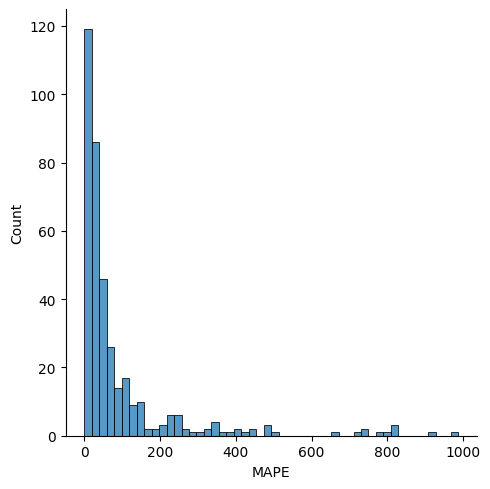

In [35]:
sns.displot(new_train_df[new_train_df["MAPE"] < 1000]["MAPE"])

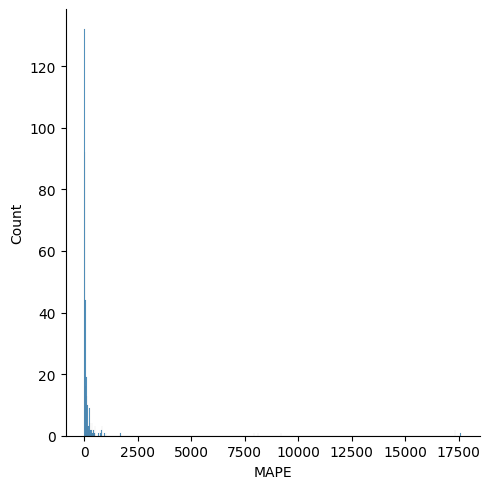

In [36]:
sns.displot(new_train_df["MAPE"])

In [37]:
print(new_train_df[new_train_df["MAPE"]> 1000][["ID", "FolderName", "RootVolume", "Preds", "MAPE"]])

                   ID  FolderName  RootVolume     Preds          MAPE
18   ID_541673_F5dfwh  Ecxdebmlnr        0.02  1.604311   7921.557617
21   ID_916044_G6ck2f  Ph2ti2sjzu        0.01  1.769635  17596.353516
46   ID_935675_Rve787  Me1ufzzcxk        0.02  1.857075   9185.374023
134  ID_884519_Vdztlr  B5myqsh1wi        0.10  1.767354   1667.353638
221  ID_862682_Lypcug  A6dzrkjqvl        0.10  1.799612   1699.611694
302  ID_794803_Tvlbyb  Rxxe9bh6qn        0.01  1.741763  17317.625000
321  ID_375653_V9hmsh  Rxxe9bh6qn        0.01  1.741763  17317.625000
379  ID_925389_Gdjxgh  Laspkqmflo        0.02  1.647357   8136.786621


In [38]:
new_train_df[new_train_df["MAPE"]> 1000]

,Unnamed: 0,ID,FolderName,PlantNumber,Side,Start,End,RootVolume,Genotype,Stage,ImageSegments,Preds,MAPE
18,18,ID_541673_F5dfwh,Ecxdebmlnr,3,R,25,36,0.02,IITA-TMS-IBA000070,Early,merged_images\train\ID_541673_F5dfwh.png,1.604311,7921.557617
21,21,ID_916044_G6ck2f,Ph2ti2sjzu,3,L,22,35,0.01,IBA980581,Early,merged_images\train\ID_916044_G6ck2f.png,1.769635,17596.353516
46,46,ID_935675_Rve787,Me1ufzzcxk,5,R,23,32,0.02,TMEB419,Early,merged_images\train\ID_935675_Rve787.png,1.857075,9185.374023
134,134,ID_884519_Vdztlr,B5myqsh1wi,5,R,26,35,0.10,TMEB419,Early,merged_images\train\ID_884519_Vdztlr.png,1.767354,1667.353638
221,221,ID_862682_Lypcug,A6dzrkjqvl,6,L,33,42,0.10,IITA-TMS-IBA000070,Early,merged_images\train\ID_862682_Lypcug.png,1.799612,1699.611694
302,302,ID_794803_Tvlbyb,Rxxe9bh6qn,7,L,31,40,0.01,IBA980581,Early,merged_images\train\ID_794803_Tvlbyb.png,1.741763,17317.625000
321,321,ID_375653_V9hmsh,Rxxe9bh6qn,4,L,31,40,0.01,IBA980581,Early,merged_images\train\ID_375653_V9hmsh.png,1.741763,17317.625000
379,379,ID_925389_Gdjxgh,Laspkqmflo,4,L,33,40,0.02,IKN130010,Early,merged_images\train\ID_925389_Gdjxgh.png,1.647357,8136.786621


Посмотрим, есть ли связь ошибки с истинным размером плода

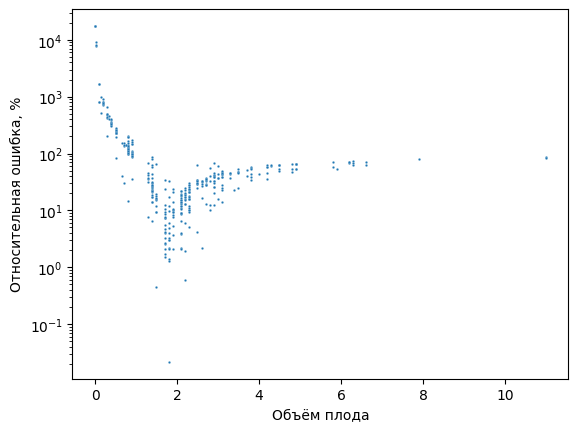

In [39]:
ax = sns.scatterplot(data=new_train_df, x='RootVolume', y='MAPE', s=3)
ax.set_yscale('log')
ax.set_ylabel("Относительная ошибка, %")
ax.set_xlabel("Объём плода")
plt.show()

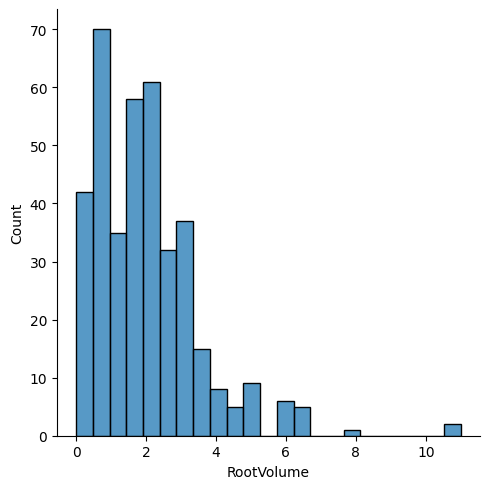

In [40]:
sns.displot(new_train_df["RootVolume"])

Выделим те данные, для которых была разметка для дообучения сегментатора

In [ ]:
labels = os.listdir("train_labels")
required = []
for label in labels:
    folderName, side = label.split("_")[:2]
    required.append((folderName, side))

[('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'L'), ('A2miww5mfx', 'R'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'L'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Aevcaxguiw', 'R'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab', 'L'), ('Cvdxhjziab

In [48]:
new_train_df["color"] = new_train_df.apply(
    lambda row: "Доп разметка" if (row["FolderName"], row["Side"]) in required else "Без", axis=1
)

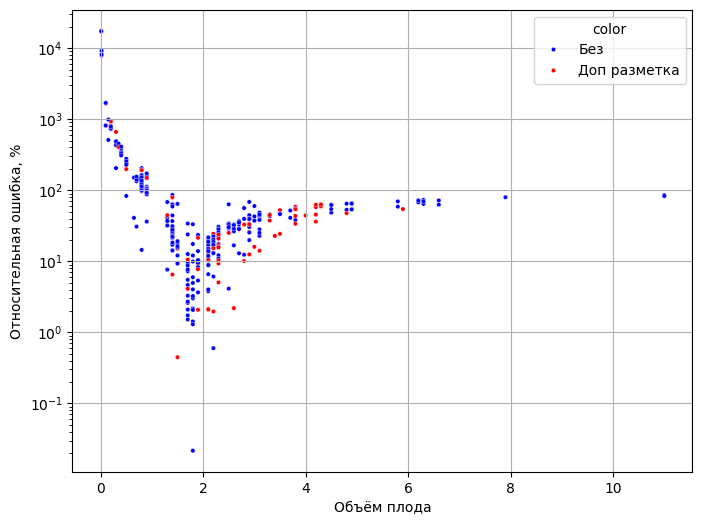

In [49]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    data=new_train_df,
    x='RootVolume',
    y='MAPE',
    hue='color',
    palette={'Доп разметка': 'red', 'Без': 'blue'},
    s=10, 
    legend='full'
)

ax.set_yscale('log')
ax.set_ylabel("Относительная ошибка, %")
ax.set_xlabel("Объём плода")
plt.grid(True)
plt.show()